<a href="https://colab.research.google.com/github/warriors8970/Gen-AI/blob/main/Image%20Generation/Diffusion%20Models/diffusion_model_5/diffusion_model_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
%pip install -Uq diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 24.1 MB/s eta 0:00:00


In [ ]:
%pip install -Uq git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
from torch import nn
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
def download_img(url):
  response = requests.get(url)
  return Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_img(img_url).resize((512,512))
mask_image = download_img(mask_url).resize((512,512))


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

(-0.5, 511.5, 511.5, -0.5)

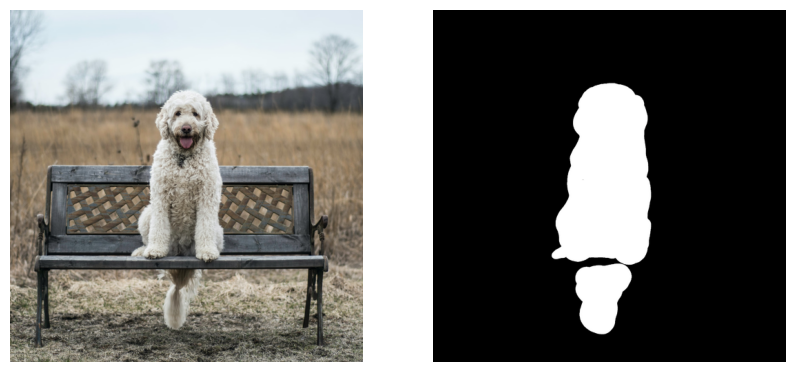

In [ ]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(init_image)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(mask_image)
plt.axis(False)

# Generating image from text

Using Stable Diffusion for this

In [ ]:
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

If pipeline is taking too much GPU storage space, we have 3 methods to make life easier:

- Load torch.float16 tensor - `pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)`
- Enable attention slicing:
`pipe.enable_attention_slicing()`
- Reduce size of images generating

# Setting up the pretrained model

  0%|          | 0/50 [00:00<?, ?it/s]

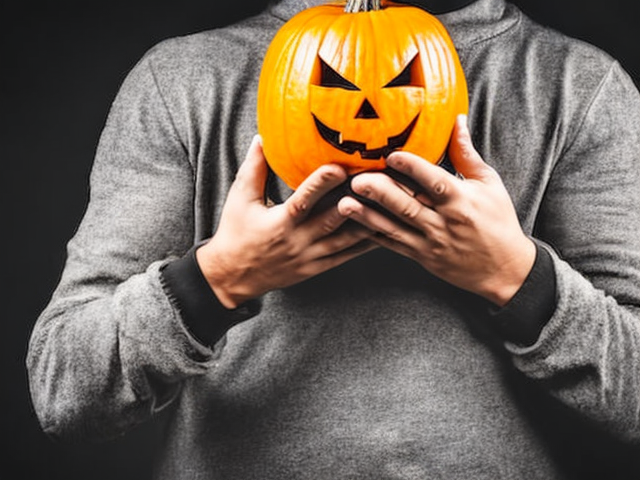

In [ ]:
generator = torch.Generator(device = device).manual_seed(42)

pipe_output = pipe(
    prompt = "scary horror background, man with pumpkin face, knife on hand",
    negative_prompt = "improper lighting, oversaturated, blurry, low quality, irrelavant",
    height = 480, width = 640,
    guidance_scale = 8,
    num_inference_steps = 50,
    generator = generator
)
pipe_output.images[0]

Use of guidance_scale⬇️

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

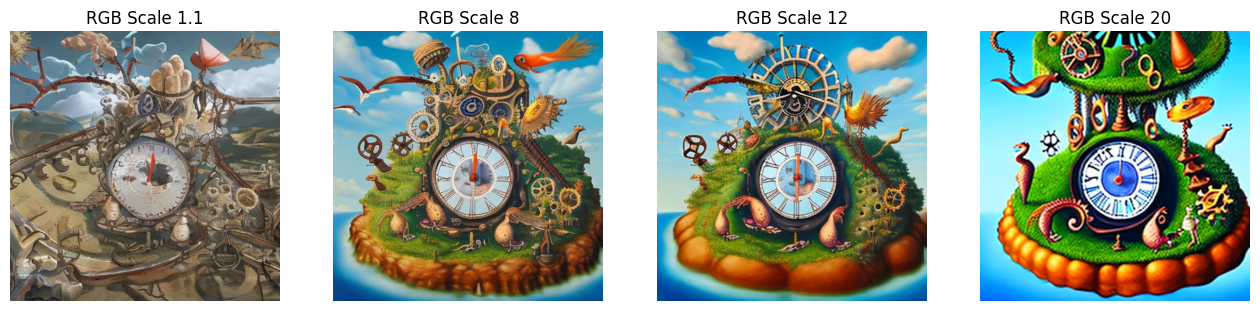

In [ ]:
cfg_scales = [1.1, 8, 12, 20]
prompt = "Surrealist painting of a floating island with giant clock gears, populated with mythical creatures"
fig, ax = plt.subplots(1, len(cfg_scales), figsize = (16,5))
for i, a in enumerate(ax):
  im = pipe(prompt, height = 480, width = 480,
            guidance_scale = cfg_scales[i], num_inference_steps = 35,
            generator = torch.Generator(device = device).manual_seed(42)).images[0]

  a.imshow(im);
  a.set_title(f"RGB Scale {cfg_scales[i]}")
  a.axis("off")

# Components
- VAE ✅
- Text Encoder ✅
- Tokenizer ✅
- UNet ✅
- Scheduler ✅


In [ ]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


## VAE

So the VAE consist of 2 parts:
- Encoder - which basically reduce the size of the image for faster computation - latent size
- Decoder - this increases the size of the image after computation

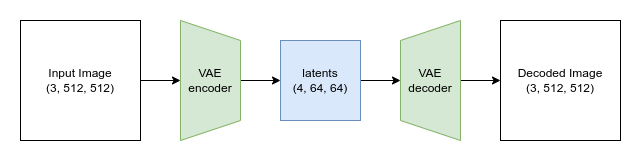

In [ ]:
image = torch.rand(1,3,512,512).to(device)*2 -1 # random tensor mapped to (-1,1)
print(f"Original shape: {image.shape}")
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(image).latent_dist.mean
  # 0.18215 is a hyperparameter for scaling - scaling constant
  # latent_dist.mean - takes the mean of the distribution

print(f"Encoded Latent shape: {latents.shape}")

with torch.no_grad():
  decoded_image = pipe.vae.decode(latents / 0.18215).sample

print(f"Decoded image shape: {decoded_image.shape}") # returns the original shape

Original shape: torch.Size([1, 3, 512, 512])
Encoded Latent shape: torch.Size([1, 4, 64, 64])
Decoded image shape: torch.Size([1, 3, 512, 512])


**Note**: The image shape should be multiples of 8 as there is 8x reduction and expansion in latent space

## The Tokenizer and Text Encoder
The whole work of this process is to convert the text i.e. string to numbers
- `Tokenizer`: This converts the text into seperate tokens
- `Text Encoder`: This converts the tokens into numbers i.e. encoding tokens - we use CLIP's pretrained text encoder

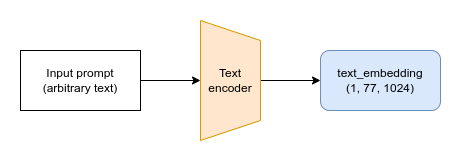

In [ ]:


#Tokenizing
input_ids = pipe.tokenizer(["A painting with no eyes"])['input_ids']
print("Input -> Decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

Input -> Decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
593 -> with
871 -> no
3095 -> eyes
49407 -> <|endoftext|>


In [ ]:
# Feeding to text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']

print(f"Text embeddings:{text_embeddings}")
print(f"\n\n Embeddings shape: {text_embeddings.shape}")

Text embeddings:tensor([[[-0.3134, -0.4476, -0.0082,  ...,  0.2542, -0.0324, -0.2960],
         [ 0.1996, -1.6936, -0.8946,  ...,  0.4658, -0.0956, -2.1484],
         [ 0.4134, -1.1114, -0.4718,  ...,  1.8329,  0.6236, -0.4375],
         ...,
         [-0.9318, -1.6930, -0.4233,  ...,  0.7614, -0.2129,  0.5666],
         [ 0.2535, -1.4274, -1.4715,  ..., -0.7703,  0.8730, -0.1338],
         [ 0.0507, -1.7709,  0.5868,  ...,  1.5992, -1.2043, -0.8527]]],
       device='cuda:0')


 Embeddings shape: torch.Size([1, 7, 1024])


In [ ]:
pipe_embeddings = pipe.encode_prompt("A painting with no eyes", device, 1, False, '')
text_embeddings=pipe_embeddings[0]
text_embeddings.shape

torch.Size([1, 77, 1024])

## UNet model

Same as previous UNet models, but 1 thing different, we give in an additional input `text_encodings`

In [ ]:
# All dummy data
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1,4,64,64).to(device)
text_embeddings = torch.randn(1,77,1024).to(device)

with torch.no_grad():
  unet_op = pipe.unet(latents, timestep, text_embeddings).sample

print('UNet output shape:', unet_op.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


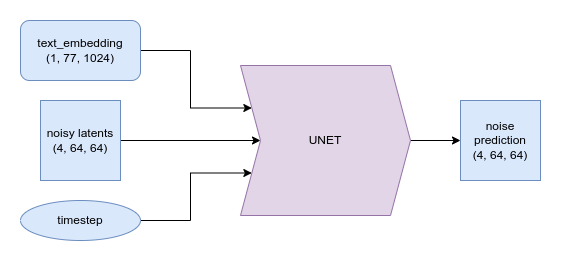

## Scheduler

`PNDMScheduler` the default one, we can use `LMSDiscreteScheduler` with correct initialization

We'll use $\bar{\alpha}$ configuration to schedule

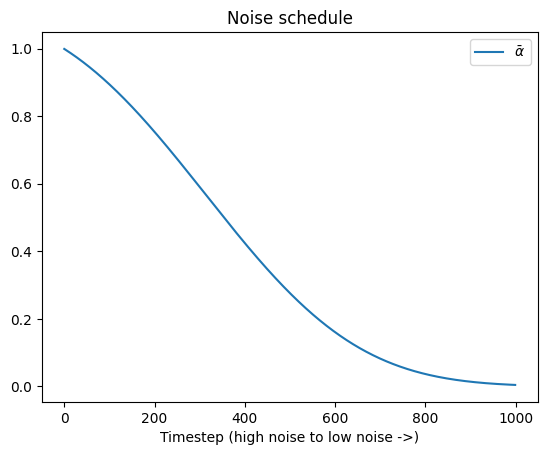

In [ ]:
# Its plot:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

Scheduelr Config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.24.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

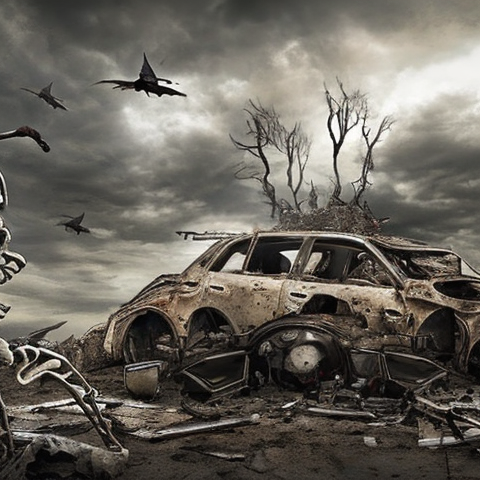

In [ ]:
from diffusers import LMSDiscreteScheduler

pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

print("Scheduelr Config:", pipe.scheduler)

pipe(prompt = "Apocalypse with broken cars and full skeleton, make it very realistic", height = 480, width= 480,
     generator = torch.Generator(device=device).manual_seed(42)).images[0]


# Sampling loop/ Training loop

Text embedding shape: torch.Size([2, 77, 1024])
Latent shape: torch.Size([1, 4, 64, 64])


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:292: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


0it [00:00, ?it/s]

Noise pred shape: torch.Size([1, 4, 64, 64])
After chunk:
Noise pred uncond shape: torch.Size([1, 4, 64, 64])
Noise pred text shape: torch.Size([1, 4, 64, 64])


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:521: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


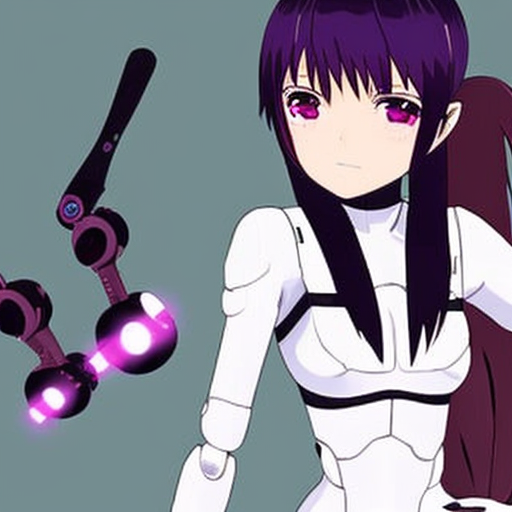

In [ ]:
from tqdm.auto import tqdm
# Input parameters
guidance_scale = 8 # 8-12 is aesthetic
num_inference_steps = 50
prompt = "A teenage AI prodigy who creates her own robotic body to escape being trapped in a virtual world, anime style"
negative_prompt = "zoomed in, blurry, oversaturated, over exposure, warped"

# Text encoding

text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)
print(f"Text embedding shape: {text_embeddings.shape}")

# random starting point
latents = torch.randn((1,4,64,64), device = device, generator = generator)
latents *= pipe.scheduler.init_noise_sigma
print(f"Latent shape: {latents.shape}")

# Setup the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device = device)

torch.cuda.manual_seed(42)

for i, t in tqdm(enumerate(pipe.scheduler.timesteps)):

  # Setting up classifier free guidance - guidance without any class
  # if the classifier free guidance is mentioned, it will be used
  latent_model_input = torch.cat([latents]*2) # it will concat anyway ;P


  # Scaling them inputs
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise as usual
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample



  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  # Chunk() is used to split the tensor along the dimension 0

  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
  # adding guidance to it

  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
  # step it output with timesteps
print(f"Noise pred shape: {noise_pred.shape}")
print("After chunk:")
print(f"Noise pred uncond shape: {noise_pred_uncond.shape}")
print(f"Noise pred text shape: {noise_pred_text.shape}")
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

pipe.numpy_to_pil(image)[0]

# Using another Pipelines Img2Img

`Functionality: ` First encodes the image into the set of latents, add some noise to the latents and use that as start point

In [ ]:
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

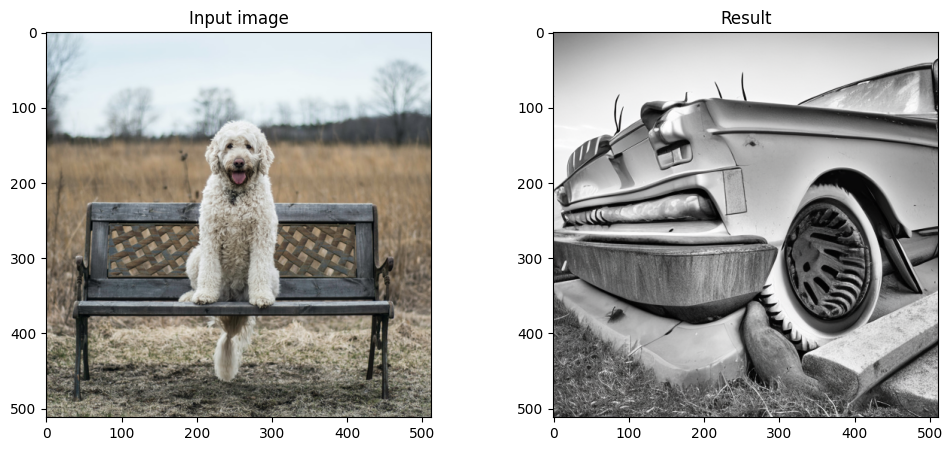

In [ ]:
result_image = img2img_pipe(
    prompt= "car on a bench",
    image = init_image,
    strength= 0.8,# 0 for no change, 1.0 for max strength

).images[0]

fig, axs = plt.subplots(1,2, figsize = (12,5))
axs[0].imshow(init_image);
axs[0].set_title('Input image')
axs[1].imshow(result_image);
axs[1].set_title('Result');

# In-painting

Change just some features of an image using a mask

We pass in another parameter - the mask of the image - should be the same size of the image

We use the `StableDiffusionInpaintPipelineLegacy` for this
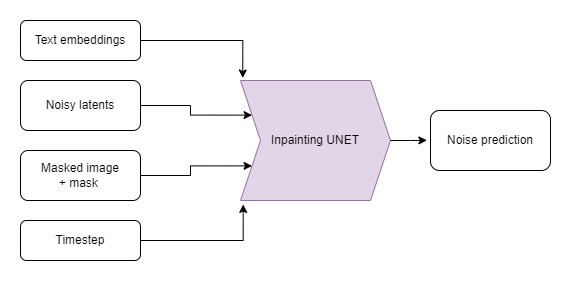

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)
pipe

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Transformed')

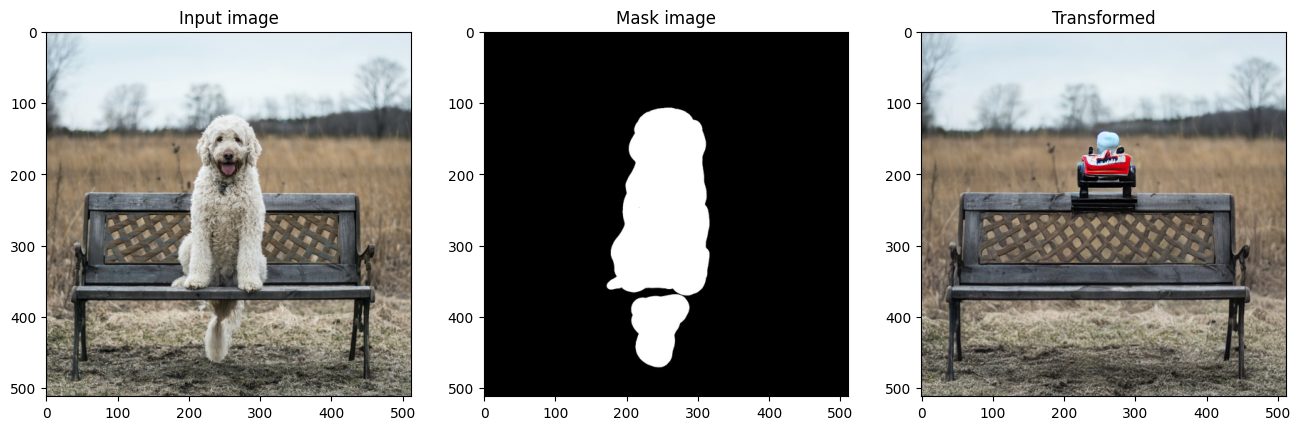

In [ ]:
prompt = "A small toy car, high resolution, sitting on a bench"
image = pipe(prompt = prompt, image = init_image, mask_image = mask_image).images[0]

fig, axs = plt.subplots(1,3, figsize = (16, 5))
axs[0].imshow(init_image); axs[0].set_title('Input image')
axs[1].imshow(mask_image); axs[1].set_title('Mask image')
axs[2].imshow(image); axs[2].set_title('Transformed')

# Depth2Img

In `In-painting` we cant like change certain details in the image. Well, `Depth2Img` does exactly that.

An additional input `depth` is given to the model for it to change effectively

In [ ]:
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

depth_estimator/config.json:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/923 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

(-0.5, 511.5, 511.5, -0.5)

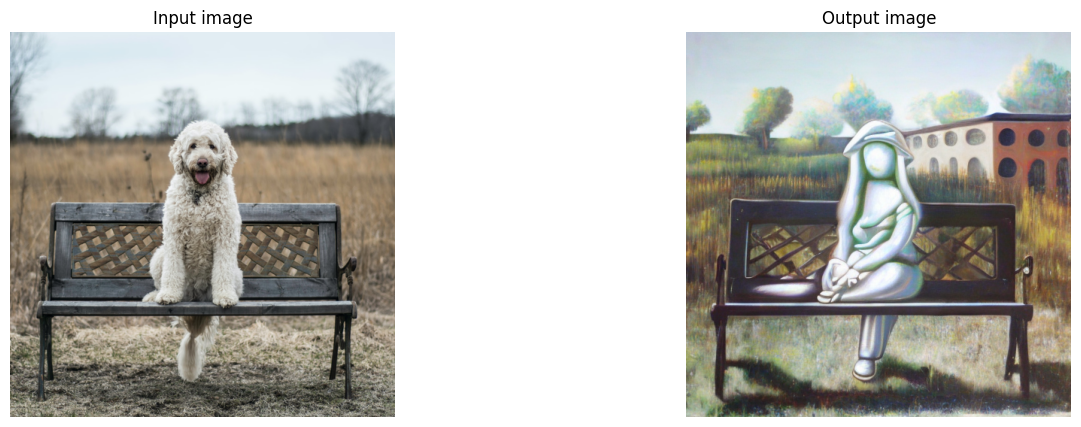

In [ ]:
prompt = "mono lisa sitting on a bench, oil painting"

image = pipe(prompt = prompt, image = init_image).images[0]

torch.cuda.manual_seed(42)

fig, axs = plt.subplots(1,2, figsize=(16,5))
axs[0].imshow(init_image); axs[0].set_title('Input image'); axs[0].axis(False)
axs[1].imshow(image); axs[1].set_title('Output image'); axs[1].axis(False)